# Data Analytics: Telecomunicaciones en Argentina

## Improtamos los datos

In [6]:
''' Importamos las librerías necesarias'''

import requests
import json
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
import copy

sns.set()

In [7]:
''' Población de las provincias de Argentina'''

url = 'https://es.wikipedia.org/wiki/Demograf%C3%ADa_de_Argentina'
tablas_poblacion = pd.read_html(url)

df_poblacion = tablas_poblacion[1]

In [8]:
''' Nos conectamos a la API donde se encuentran los'''

llave_file = open('C:/Users/Luis/Documents/Universidad-Trabajo/SoyHenry/LABS/Proyecto_2/llave_api.txt')
llave = llave_file.read()

key = llave

response = requests.get("http://api.datosabiertos.enacom.gob.ar/api/v2/dashboards/ACCES-A-INTER.json/?auth_key={}".format(key))

if response.status_code == 200:
    print('Conectado')
else:
    print('No conectado')

Conectado


In [9]:
''' Creamos un diccionario con la respuesta de la API'''

datos = json.loads(response.text)

In [10]:
''' Creamos una lista con los valores de la key resources, que es donde se encuentran los datasets'''

lista_datos = datos['resources']

In [11]:
''' Nos quedamos solo con los diccionarios de las tablas, las cuales pasaremos a una lista'''

lista_datasets = []
for l in lista_datos:
    if 'doc_type' in list(l.keys()):
        if l['doc_type'] == 'datastream':
            lista_datasets.append(l)

In [12]:
''' Creamos una función que nos permitirá traer las tablas de la API'''

def crear_dataframe(lista_apis, posicion, llave, ruta):

    guid = lista_apis[posicion]['guid']
    tabla_respuesta = requests.get("http://api.datosabiertos.enacom.gob.ar/api/v2/datastreams/{}/data.csv/?auth_key={}".format(guid,llave))
    if tabla_respuesta.status_code == 200:
        tabla_respuesta.encoding = 'uft-8'
        return pd.read_csv(StringIO(tabla_respuesta.text), sep = ",", encoding = 'latin1', thousands = '.', decimal = ',')
    elif guid == 'ACCES-A-INTER-FIJO-POR':
        return pd.read_excel(ruta, thousands = '.', decimal = ',')
    else:
        return pd.read_csv(ruta, thousands = '.', decimal = ',')

In [13]:
''' Creamos las tablas que se usarán en el EDA'''

df_totales_acceso_fijo_bandas = crear_dataframe(lista_datasets, 0, key, 'C:/Users/Luis/Documents/Universidad-Trabajo//SoyHenry/LABS/Proyecto_2/Datasets/accesos_nacionales_internet_banda.csv')
df_acceso_provincia_bandas = crear_dataframe(lista_datasets, 1, key, 'C:/Users/Luis/Documents/Universidad-Trabajo//SoyHenry/LABS/Proyecto_2/Datasets/accesos_internet_banda_provincia.csv')
df_tecnologia = crear_dataframe(lista_datasets, 2, key, 'C:/Users/Luis/Documents/Universidad-Trabajo//SoyHenry/LABS/Proyecto_2/Datasets/accesos_internet_tecnologia_provincia.xlsx')
df_acceso_velocidad_rangos_bajada_provincia = crear_dataframe(lista_datasets, 4, key, 'C:/Users/Luis/Documents/Universidad-Trabajo//SoyHenry/LABS/Proyecto_2/Datasets/accesos_internet_rangos_velocidad_provincia.csv')

## Analizamos los diferentes dataframes

In [14]:
''' Veamos primero la tabla de poblacion, la cual nos ayudará a hacer algunas conclusiones'''

df_poblacion.head()

,Provincia,Población en 2022[20]​>
0,Buenos Aires,17.569.053
1,Córdoba,3.978.984
2,Santa Fe,3.556.522
3,Ciudad Autónoma de Buenos Aires,3.120.612
4,Mendoza,2.014.533


In [15]:
''' Cambiamos los puntos por espacios en blanco en la columna población en 2022[20] y convertimos a int'''

df_poblacion['Población en 2022[20]\u200b>'] = df_poblacion['Población en 2022[20]\u200b>'].apply(lambda x: x.replace('.', ''))
df_poblacion['Población en 2022[20]\u200b>'] = df_poblacion['Población en 2022[20]\u200b>'].astype(int)

In [16]:
''' Cambiamos el nombre de la provincia Tierra del Fuego y Ciudad Autónoma de Buenos Aires'''

df_poblacion['Provincia'].replace({'Ciudad Autónoma de Buenos Aires': 'Capital Federal', 'Tierra del Fuego, Antártida e Islas del Atlántico Sur': 'Tierra Del Fuego', 'Santiago del Estero': 'Santiago Del Estero'}, inplace = True)

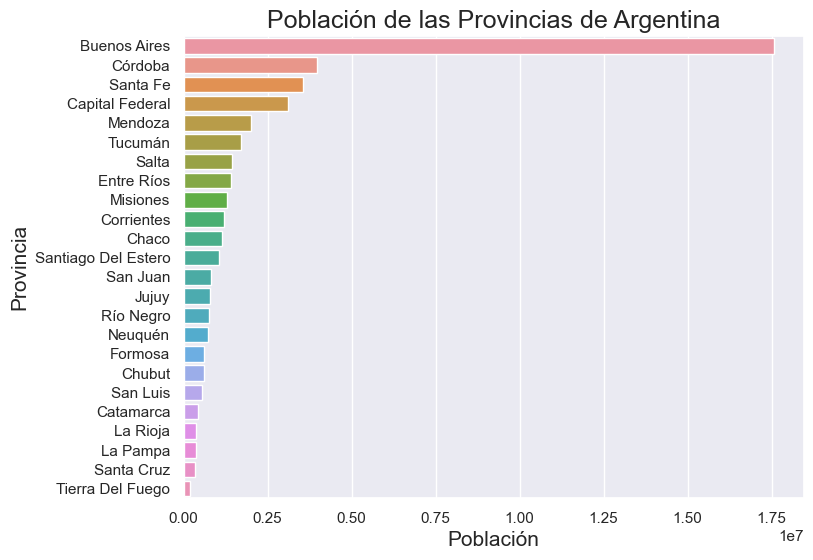

In [17]:
''' Veamos la distribución de la población con un gráfico de barras'''

plt.figure(figsize = (8, 6))

sns.barplot(df_poblacion, x = 'Población en 2022[20]\u200b>', y = 'Provincia', orient = 'h')
plt.xlabel('Población', fontsize = 15)
plt.ylabel('Provincia', fontsize = 15)
plt.title('Población de las Provincias de Argentina', fontsize = 18)

plt.show()

In [18]:
''' Ahora veamos el df_totales_acceso_fijo_bandas'''

df_totales_acceso_fijo_bandas.head()

,Año,Trimestre,Banda ancha fija,Dial up,Total,Periodo
0,2022,3,11078691,12437,11091128,Jul-Sept 2022
1,2022,2,10946248,12436,10958684,Abr-Jun 2022
2,2022,1,10611390,12619,10624009,Ene-Mar 2022
3,2021,4,10476933,12861,10489794,Oct-Dic 2021
4,2021,3,10075184,10357,10085541,Jul-Sept 2021


In [19]:
''' Creamos una tabla que agrupe la información por año'''

df_nacional_anual = df_totales_acceso_fijo_bandas.groupby('Año')[['Banda ancha fija', 'Dial up', 'Total']].sum().reset_index()
df_nacional_anual.head()

,Año,Banda ancha fija,Dial up,Total
0,2014,25908873,147760,26056633
1,2015,27337549,136270,27473819
2,2016,28373776,122282,28496058
3,2017,30217820,112863,30330683
4,2018,32865578,102609,32968187


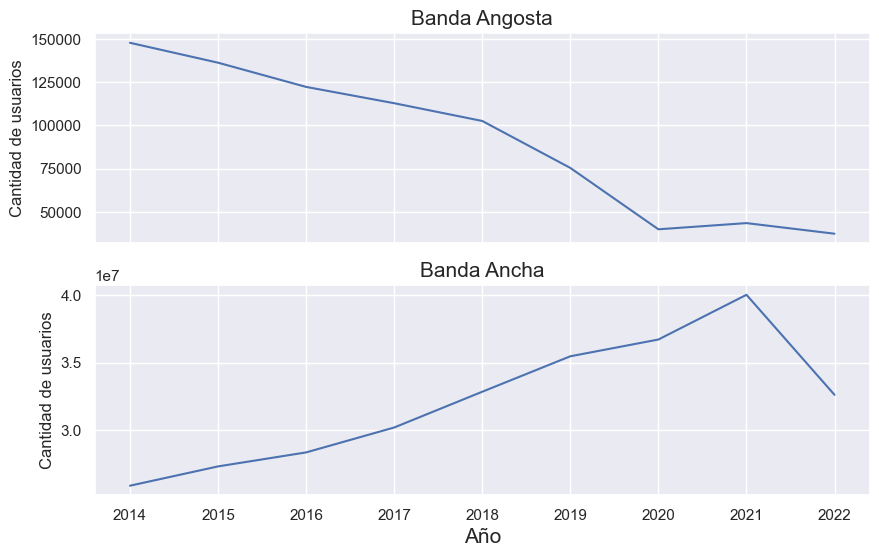

In [20]:
''' Observemos graficamente la diferencia entre la cantidad de usuarios de banda ancha y angosta por año'''

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 6), sharex = True)
sns.lineplot(df_nacional_anual, x = 'Año',  y = 'Dial up', ax = ax1)
ax1.set_title("Banda Angosta", fontsize = 15)
ax1.set_xlabel("Año")
ax1.set_ylabel("Cantidad de usuarios")

sns.lineplot(df_nacional_anual, x = 'Año', y = 'Banda ancha fija', ax = ax2)
ax2.set_title("Banda Ancha", fontsize = 15)
ax2.set_xlabel("Año", fontsize = 15)
ax2.set_ylabel("Cantidad de usuarios")

plt.show()

Observamos la gran diferencia entre la cantidad de usuarios. La cantidad de banda ancha es mayor a 2,5 millones mientras que en banda angosta no llega a 200 mil. Además, la cantidad en banda angosta va disminuyendo año a año. Esto nos indica que los usuarios de banda angosta están migrando a banda ancha y que la mayor posibilidad de crecimiento para la empresa sería enfocándose en las tecnologías que ofrezcan el servicio de internet por banda ancha.

Es notorio que la cantidad de usuarios de banda ancha disminuye en el año 2022 con respecto a años anteriores. Esto se debe a que falta la información del cuarto trimestre en el año 2022. Además, a las dificultades económicas que presenta el país actualmente, lo que hace difícil que las personas puedan seguir pagando el servicio de internet.

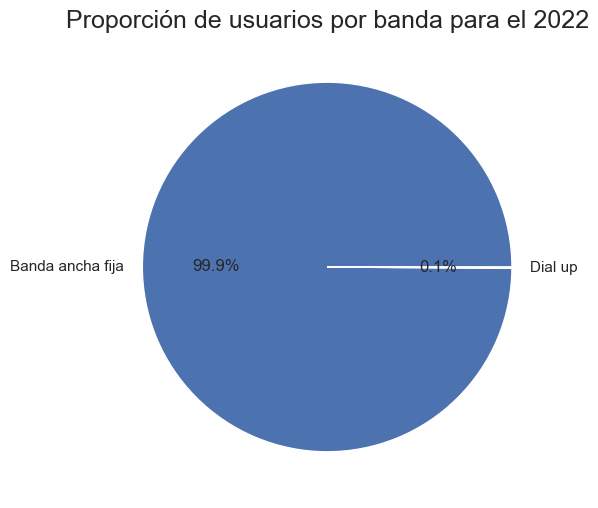

In [21]:
''' Veamos la proporción para los usuarios de banda angosta y banda ancha para el año 2022 con un gráfico de torta'''

label = list(df_nacional_anual[df_nacional_anual['Año'] == 2022].drop(columns = ['Total', 'Año']).columns)


plt.figure(figsize = (8, 6))
plt.pie(df_nacional_anual[df_nacional_anual['Año'] == 2022].drop(columns = ['Total', 'Año']).iloc[0], labels = label, autopct = '%1.1f%%')
plt.title('Proporción de usuarios por banda para el 2022', fontsize = 18)

plt.show()

En el gráfico vemos que solo el 0.1% de los usuarios utilizan Dial up o banda angosta para el año 2022, mientras que el 99.9% utilizan banda ancha en el mismo año. Esto está acorde a los visto en el gráfico anterior, donde la cantidad de usuarios de banda angosta ha disminuido a lo largo de los años y es menor a la cantidad de usuarios de banda ancha.

Este gráfico reafirma la necesidad de que la empresa solo enfoque sus esfuerzos en adquirir nuevos usuarios mediante tecnologías que oferten internet de banda ancha, pues es el que tiene mayor demanda en el mercado.

In [22]:
''' Observemos ahora el dataframe df_acceso_provincia_bandas'''

df_acceso_provincia_bandas.head()

,Año,Trimestre,Provincia,Banda ancha fija,Dial up,Total
0,2022,3,Buenos Aires,4715469,6.199,4721668
1,2022,3,Capital Federal,1545534,2.145,1547679
2,2022,3,Catamarca,70292,1,70293
3,2022,3,Chaco,144141,5,144146
4,2022,3,Chubut,164874,904,165778


In [23]:
''' Vemos que la tabla tiene unos valores nulos en Dial up, si se suman los valores de las dos filas se obtiene el valor 
    del total, por lo que el valor de Dial up en esas filas debe ser cero, por esto se asigna 0 a los valores nulos'''

df_acceso_provincia_bandas.fillna(0, inplace = True)

In [24]:
''' Reemplazamos los valores "- 0" por 0'''

df_acceso_provincia_bandas['Dial up'].replace({"- 0": "0"}, inplace = True)

In [25]:
''' Quitamos los puntos que representan miles y convertimos a entero'''

df_acceso_provincia_bandas['Dial up'] = df_acceso_provincia_bandas['Dial up'].astype(str)
df_acceso_provincia_bandas['Dial up'] = df_acceso_provincia_bandas['Dial up'].apply(lambda x: x.replace('.', ''))
df_acceso_provincia_bandas['Dial up'] = df_acceso_provincia_bandas['Dial up'].astype(int)

In [26]:
''' Creamos una nueva tabla que agrupe la información por provincia'''

df_provincia_banda_anual = df_acceso_provincia_bandas.groupby(["Provincia"])[["Banda ancha fija", "Dial up", "Total"]].sum().reset_index()
df_provincia_banda_anual.head()

,Provincia,Banda ancha fija,Dial up,Total
0,Buenos Aires,123014356,340191,123354547
1,Capital Federal,48866626,204979,49071605
2,Catamarca,1311807,327,1312134
3,Chaco,3678217,468,3678685
4,Chubut,3328819,54067,3382886


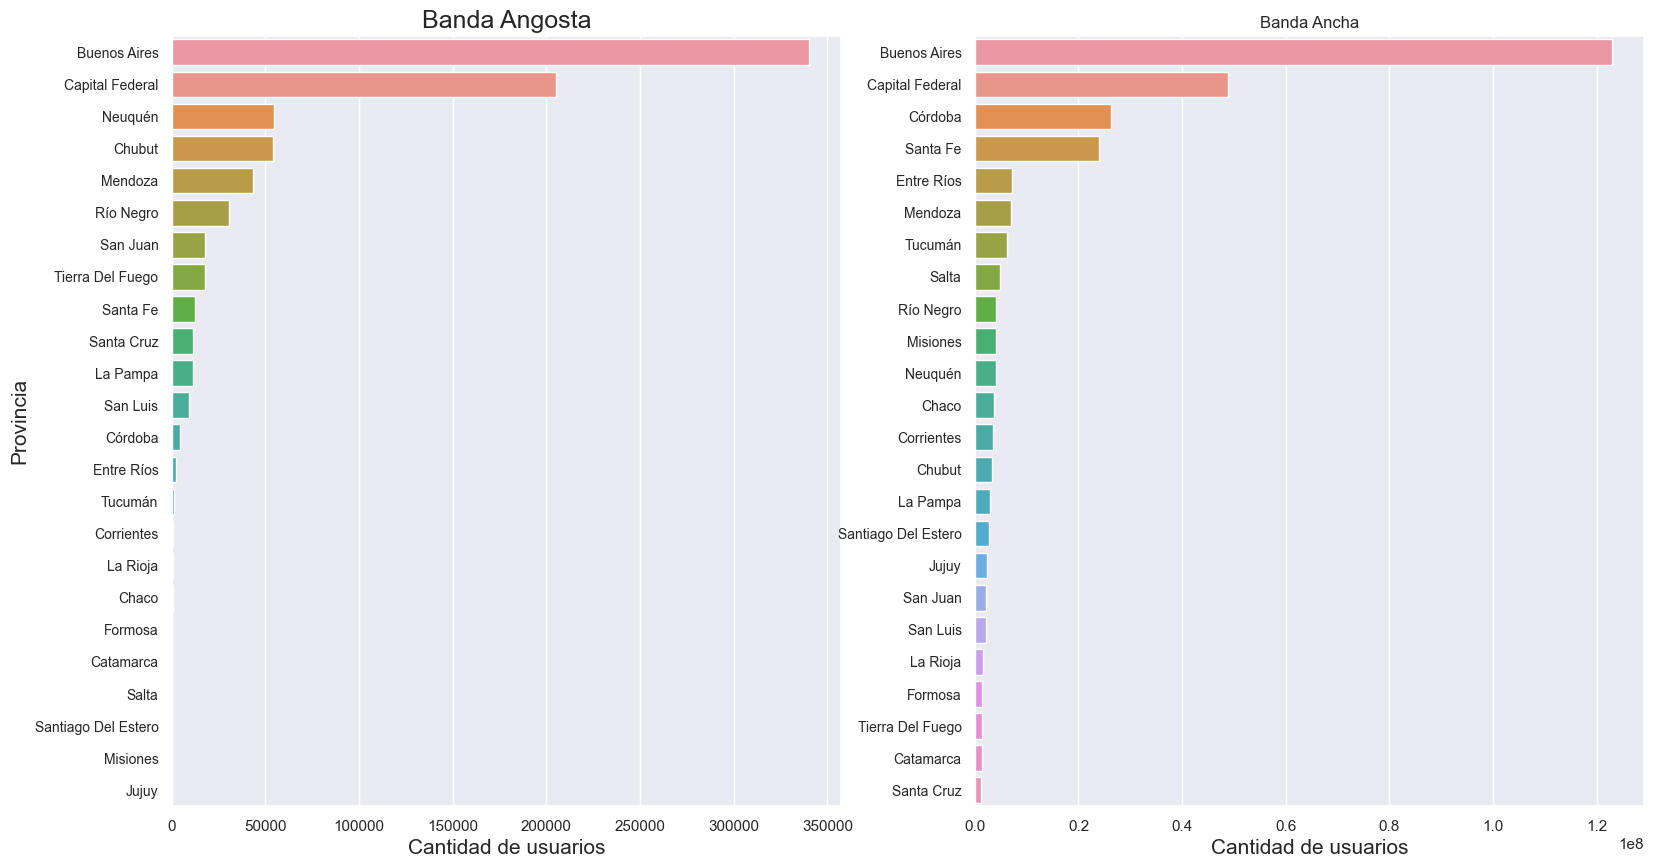

In [27]:
''' Observemos la cantidad de usuarios para ambas bandas por provincia.'''

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (19, 10))
sns.barplot(df_provincia_banda_anual.sort_values(by = 'Dial up',ascending = False), y = 'Provincia',  x = 'Dial up', ax = ax1, orient = "h", errorbar = None)
ax1.set_title("Banda Angosta", fontsize = 18)
ax1.set_xlabel("Cantidad de usuarios", fontsize = 15)
ax1.set_ylabel("Provincia", fontsize = 15)
ax1.tick_params(axis = 'y', labelsize = 10)

sns.barplot(df_provincia_banda_anual.sort_values(by = 'Banda ancha fija',ascending = False), y = 'Provincia', x = 'Banda ancha fija', ax = ax2, orient = "h", errorbar = None)
ax2.set_title("Banda Ancha")
ax2.set_ylabel('')
ax2.set_xlabel("Cantidad de usuarios", fontsize = 15)
ax2.tick_params(axis = 'y', labelsize = 10)

plt.show()

Vemos que no todas las provincias tienen servicio de internet con banda angosta, mientras que todas si tienen internet con banda ancha. Se observa que la cantidad de usuarios de internet de banda angosta es mucho menor a los usuarios con internet de banda ancha, esto coincide con el análisis realizado previamente.

Es importante señalar que las provincias con mayor cantidad de usuarios con banda angosta son Buenos Aires y Capital Federal, lo que representa un posible punto de mejora al ofrecer alternativas a estos usuarios, para que realicen la migración y tengan una mejor calidad del servicio de internet.

Por está razón, el análisis presentado en este Notebook se enfocará en banda ancha.

In [28]:
''' Análicemos el dataset de accesos por cada 100 hogares'''

df_100 = pd.read_csv('C:/Users/Luis/Documents/Universidad-Trabajo//SoyHenry/LABS/Proyecto_2/Datasets/accesos_100.csv', thousands = '.', decimal = ',')
df_100.head()

,Año,Trimestre,Provincia,Accesos por cada 100 hogares
0,2022,3,Buenos Aires,78.11
1,2022,3,Capital Federal,122.28
2,2022,3,Catamarca,65.33
3,2022,3,Chaco,43.86
4,2022,3,Chubut,84.38


In [29]:
''' Realicemos un merge entre el df_100 y df_accesos_provincia_bandas'''

df_banda_100 = df_acceso_provincia_bandas.merge(df_100, on = ['Año', 'Trimestre', 'Provincia'])
df_banda_100.drop(columns = ['Dial up', 'Total'], inplace = True)
df_banda_100.head()

,Año,Trimestre,Provincia,Banda ancha fija,Accesos por cada 100 hogares
0,2022,3,Buenos Aires,4715469,78.11
1,2022,3,Capital Federal,1545534,122.28
2,2022,3,Catamarca,70292,65.33
3,2022,3,Chaco,144141,43.86
4,2022,3,Chubut,164874,84.38


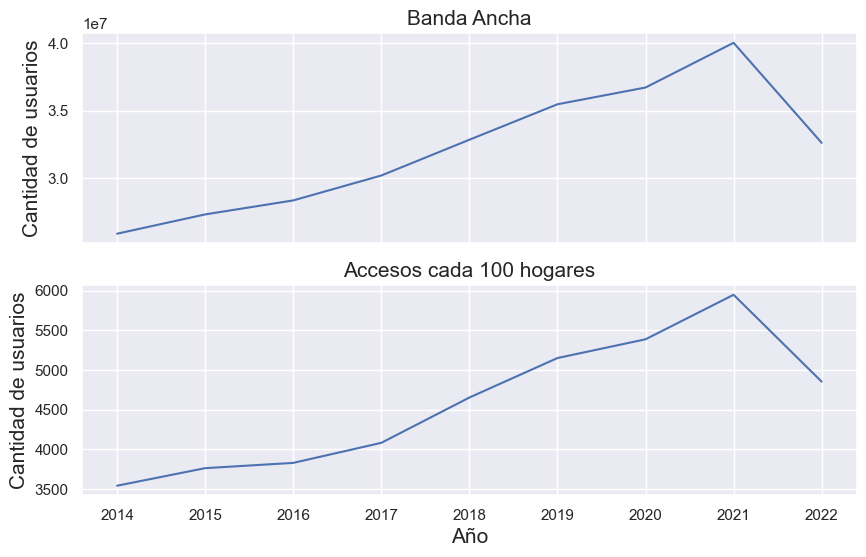

In [30]:
''' Realicemos una comparación entre la evolución de banda ancha y el acceso cada 100 hogares anualmente'''

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 6), sharex = True)
sns.lineplot(df_banda_100.groupby(['Año'])[['Banda ancha fija', 'Accesos por cada 100 hogares']].sum().reset_index(), x = 'Año',  y = 'Banda ancha fija', ax = ax1)
ax1.set_title("Banda Ancha", fontsize = 15)
ax1.set_xlabel("Año")
ax1.set_ylabel("Cantidad de usuarios", fontsize = 15)

sns.lineplot(df_banda_100.groupby(['Año'])[['Banda ancha fija', 'Accesos por cada 100 hogares']].sum().reset_index(), x = 'Año', y = 'Accesos por cada 100 hogares', ax = ax2)
ax2.set_title("Accesos cada 100 hogares", fontsize = 15)
ax2.set_xlabel("Año", fontsize = 15)
ax2.set_ylabel("Cantidad de usuarios", fontsize = 15)

plt.show()

En el gráfico observamos un comportamiento similar entre la cantidad de usuarios conectados a banda ancha fija y la cantidad accesos cada 100 hogares. Esto tiene sentido porque ambas variables están relacionadas, es decir, a medida que hay más cantidad de hogares con acceso a internet entonces habrán más usuarios con acceso a internet.

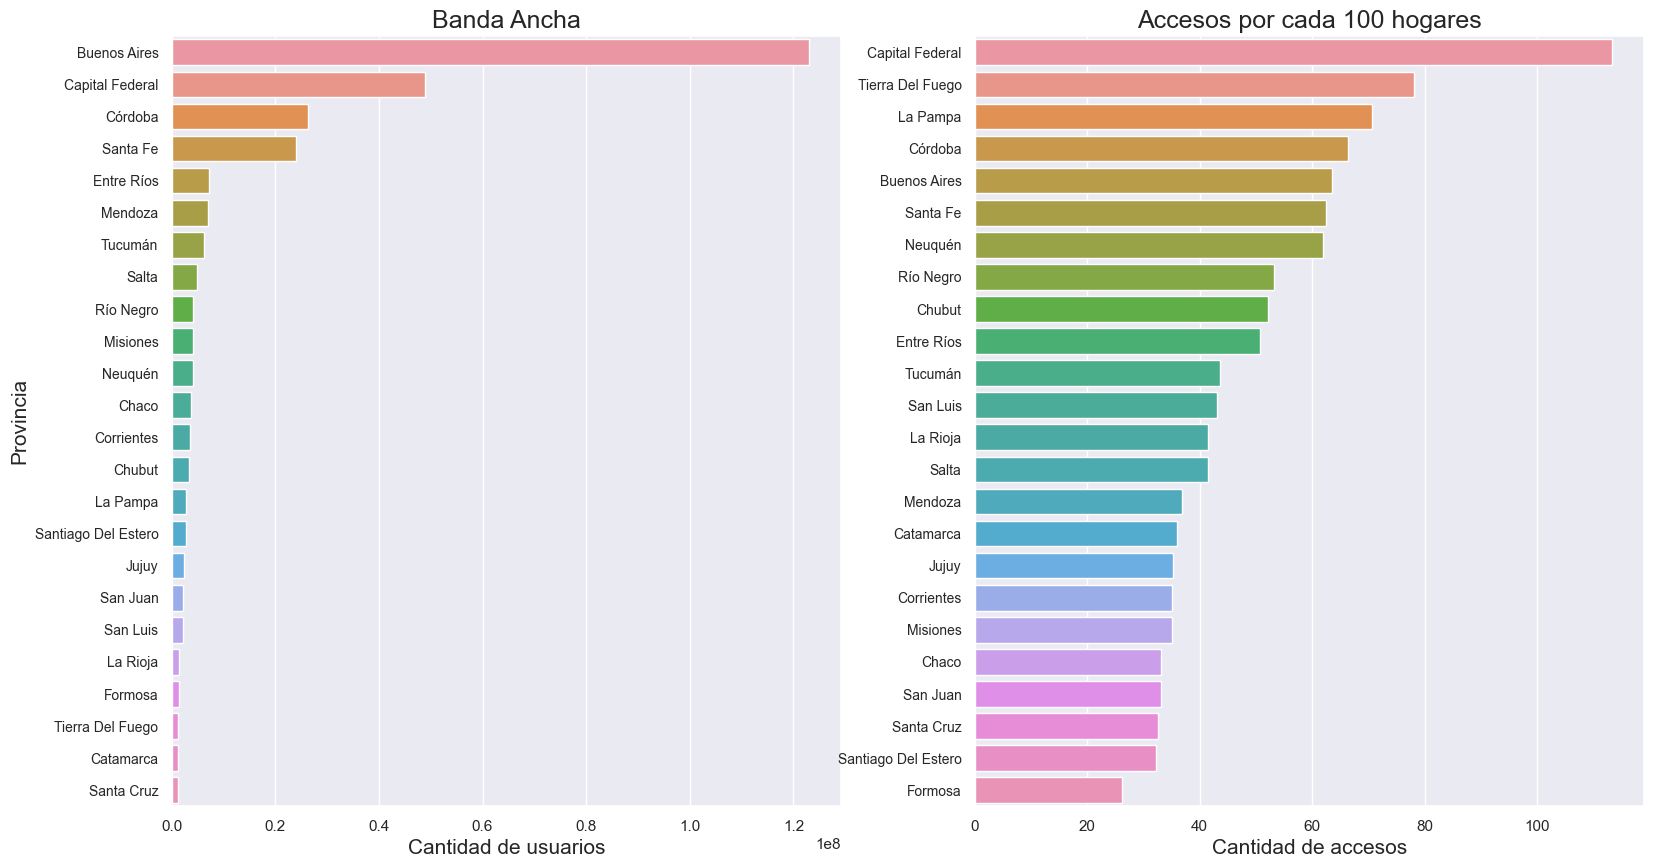

In [31]:
''' Observemos ahora la cantidad de usuarios con banda ancha y el acceso por cada 100 hogares por provincia.'''

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (19, 10))
sns.barplot(df_banda_100.groupby(['Provincia'])[['Banda ancha fija', 'Accesos por cada 100 hogares']].sum().reset_index().sort_values(by = 'Banda ancha fija', ascending = False), y = 'Provincia',  x = 'Banda ancha fija', ax = ax1, orient = "h", errorbar = None)
ax1.set_title("Banda Ancha", fontsize = 18)
ax1.set_xlabel("Cantidad de usuarios", fontsize = 15)
ax1.set_ylabel("Provincia", fontsize = 15)
ax1.tick_params(axis = 'y', labelsize = 10)

sns.barplot(df_banda_100.groupby(['Provincia'])[['Banda ancha fija', 'Accesos por cada 100 hogares']].mean().reset_index().sort_values(by = 'Accesos por cada 100 hogares', ascending = False), y = 'Provincia', x = 'Accesos por cada 100 hogares', ax = ax2, orient = "h", errorbar = None)
ax2.set_title("Accesos por cada 100 hogares", fontsize = 18)
ax2.set_ylabel('')
ax2.set_xlabel("Cantidad de accesos", fontsize = 15)
ax2.tick_params(axis = 'y', labelsize = 10)

plt.show()

En el gráfico vemos una comparación entre la cantidad de usuarios de banda ancha fija y la cantidad de hogares con acceso a internet. Acá es importante primero mencionar que la cantidad de accesos se basa en la cantidad total de la población, se puede considerar como el porcentaje de la población con acceso a internet.

Podemos ver como a pesar de que Buenos Aires es la provincia con mayor cantidad de usuarios, es a penas la quinta provincia con mayor cantidad de hogares con acceso a internet.

Del gráfico es importante ver las últimas provincias con acceso a internet, pues son las provincias en las que hay mayor oportunidad de crecimiento para la compañía si se realiza la inversión correcta y se proveen los planes ideales, a precios accesibles para la población.

**Ya que se ha analizado la cantidad de usuarios en banda ancha, banda angosta y la cantidad de accesos por hogar, vemos la cantidad de usuarios en relación de los diferentes rangos de velocidad disponibles y las tecnologías disponibles en el mercado.**

In [32]:
''' Analizamos el dataframe df_acceso_velocidad_rangos_bajada_provincia'''

df_acceso_velocidad_rangos_bajada_provincia.head()

,Año,Trimestre,Provincia,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
0,2022,3,Buenos Aires,29985,27709,290315,297915,267044,124190,3618689,65821.0,4721668
1,2022,3,Capital Federal,517,5742,34371,67829,51946,28692,1253105,105477.0,1547679
2,2022,3,Catamarca,71,384,3107,5389,5099,3737,50298,2208.0,70293
3,2022,3,Chaco,461,987,16782,18938,8049,15828,79390,3711.0,144146
4,2022,3,Chubut,109,1444,45707,30940,34682,15309,17563,20024.0,165778


In [33]:
''' Vemos que hay 6 valores nulos en la columna OTROS, los reemplazamos por 0'''

df_acceso_velocidad_rangos_bajada_provincia['OTROS'].fillna(0, inplace = True)

In [34]:
''' Vemos que trimestre, año y provincia se pueden utilizar para categorizar los datos, por lo que se 
    convierten a category'''

df_acceso_velocidad_rangos_bajada_provincia['Año'] = df_acceso_velocidad_rangos_bajada_provincia['Año'].astype('category')
df_acceso_velocidad_rangos_bajada_provincia['Trimestre'] = df_acceso_velocidad_rangos_bajada_provincia['Trimestre'].astype('category')
df_acceso_velocidad_rangos_bajada_provincia['Provincia'] = df_acceso_velocidad_rangos_bajada_provincia['Provincia'].astype('category')

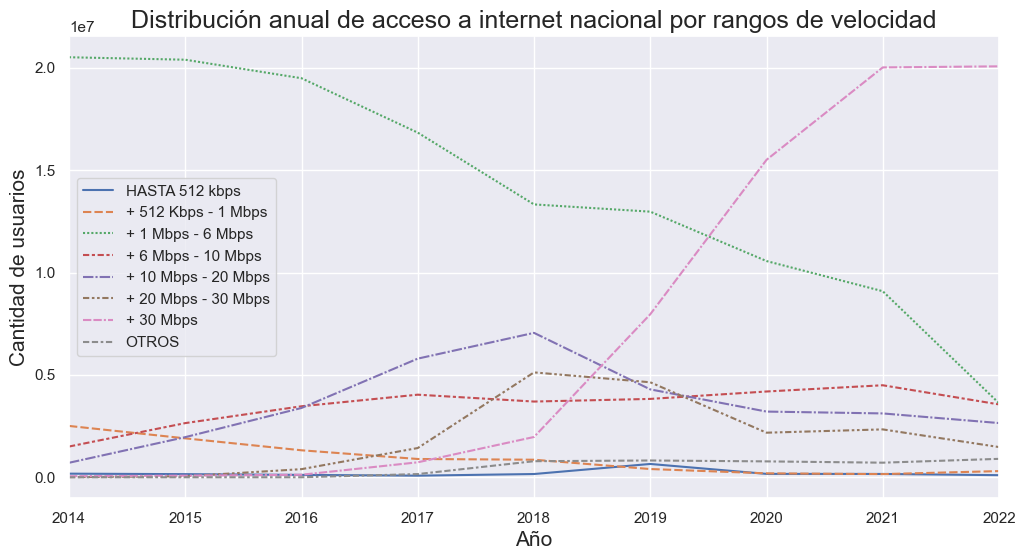

In [35]:
''' Veamos el progreso anual de los rangos de velocidad con un gráfico de líneas'''

label = list(reversed(list(df_acceso_velocidad_rangos_bajada_provincia['Año'].unique())))

plt.figure(figsize = (12, 6))
sns.lineplot(df_acceso_velocidad_rangos_bajada_provincia.groupby(['Año'])[['HASTA 512 kbps', '+ 512 Kbps - 1 Mbps', '+ 1 Mbps - 6 Mbps', '+ 6 Mbps - 10 Mbps', '+ 10 Mbps - 20 Mbps', '+ 20 Mbps - 30 Mbps', '+ 30 Mbps', 'OTROS']].sum().reset_index().drop(columns = ['Año']))
plt.xlim(0, 8)
x_ticks = plt.xticks()[0]
plt.xticks(x_ticks, labels = label)
plt.xlabel('Año', fontsize = 15)
plt.ylabel('Cantidad de usuarios', fontsize = 15)
plt.title('Distribución anual de acceso a internet nacional por rangos de velocidad', fontsize = 18)

plt.show()

Vemos que a medida que pasan los años, la cantidad de usuarios que tienen internet con velocidades de más de 30 Mbps aumentan, de +6 a 10 Mbps se mantiene constante y las demás velocidades disminuyen. Esto muestra la necesidad de la población por adquirir un internet de mayor velocidad que le permita tener un mejor y más rápido acceso. 

El hecho de que la velocidad entre 6 y 10 Mbps se mantenga constante se debe a que el costo del servicio es más accesible para los usuarios. Estas velocidades presentan un rendimiento satisfactorio, es decir, cumple con lo mínimo que necesitan los usuarios en general. Por otro lado, la velocidad de internet de +1 a 6 Mbs, que tenía la mayor cantidad de usuarios hasta 2019, disminuyó mucho más que las demás velocidades, esto es a razón del COVID-19. La pandemia creó la necesidad de las personas en tener mejores servicios de internet que le permitieran realizar videollamadas a familiares y amigos. Además, ayudó al aumento del trabajo remoto, creando también la necesidad de tener un mejor internet para poder trabajar.

Este comportamiento va acorde con la disminución de los usuarios de internet que tienen banda angosta, la cual tiene velocidades de internet menores a 512 Kbps, en el gráfico se observa que esta velocidad tiene la menor cantidad de usuarios para el 2022.

Por esto, para adquirir más usuarios, la empresa debe enfocarse en ofertar planes de internet con buenas velocidades a precios accesibles, es decir, velocidades entre 6 y 10 Mbps y más de 30 Mbps. 

In [36]:
''' Creemos un nuevo dataframe que contendrá la cantidad de usuarios para +6 a 10 Mbps y + 30 Mbps, los demás valores
    se agruparan en una columna llamada OTROS, que contedrá la suma de los usuarios. También, eliminamos la columna
    total del dataframe de acceso por rango de velocidad original'''

df_velocidad_porcentaje = copy.deepcopy(df_acceso_velocidad_rangos_bajada_provincia)
df_velocidad_porcentaje['OTROS'] = df_velocidad_porcentaje['OTROS'] + df_velocidad_porcentaje['HASTA 512 kbps'] + df_velocidad_porcentaje['+ 512 Kbps - 1 Mbps'] + df_velocidad_porcentaje['+ 1 Mbps - 6 Mbps'] + df_velocidad_porcentaje['+ 10 Mbps - 20 Mbps'] + df_velocidad_porcentaje['+ 20 Mbps - 30 Mbps']
df_velocidad_porcentaje.drop(columns = ['HASTA 512 kbps', '+ 512 Kbps - 1 Mbps', '+ 1 Mbps - 6 Mbps', '+ 10 Mbps - 20 Mbps', '+ 20 Mbps - 30 Mbps'], inplace = True)

df_acceso_velocidad_rangos_bajada_provincia.drop(columns = ['Total'], inplace = True)


In [37]:
''' Dividimos las columnas + 6 Mbps a 10 Mbps, + 30 Mbps y OTROS entre el Total y multiplicamos por 100, para obtener
    el porcentaje de la pobalción para cada velocidad de conexión'''

df_velocidad_porcentaje['+ 6 Mbps - 10 Mbps'] = df_velocidad_porcentaje['+ 6 Mbps - 10 Mbps'] / df_velocidad_porcentaje['Total'] * 100
df_velocidad_porcentaje['+ 30 Mbps'] = df_velocidad_porcentaje['+ 30 Mbps'] / df_velocidad_porcentaje['Total'] * 100
df_velocidad_porcentaje['OTROS'] = df_velocidad_porcentaje['OTROS'] / df_velocidad_porcentaje['Total'] * 100

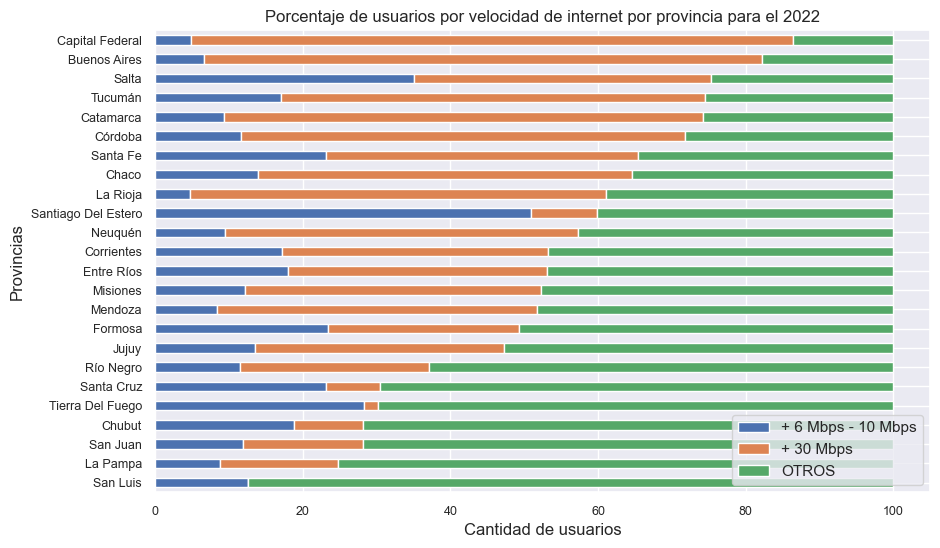

In [38]:
''' Observemos la cantidad de usuarios por velocidad de internet por provincias para el año 2022'''

df_velocidad_porcentaje[df_velocidad_porcentaje['Año'] == 2022].groupby(['Provincia'])[['+ 6 Mbps - 10 Mbps', '+ 30 Mbps', 'OTROS']].mean().sort_values(by = 'OTROS', ascending = False).plot(kind = 'barh', stacked = True, title = 'Porcentaje de usuarios por velocidad de internet por provincia para el 2022', figsize = (10, 6), ylabel = 'Provincias', xlabel = 'Cantidad de usuarios', fontsize = 9)

plt.show()

En el gráfico observamos que la mayoría de las provincias cuentan, principalmente, con velocidades de internet entre 6 y 10 Mbps y mayores a 30 Mbps para el 2022. Esto concuerda con el gráfico anterior, donde se observó el gran aumento de usuarios con velocidades de internet mayores a 30 Mbps y como la cantidad de usuarios entre 6 y 10 Mbps se ha mantenido constante a lo largo de los años

Este gráfico nos ayuda a ver provincias como San Luis O Tierra Del Fuego, las cuales cuentan con pocos usuarios que tienen internet con velocidades mayores a los 30 Mbps. Son en estas provincias donde se debe enfocar el mejoramiento del servicio de internet, para ofrecerle a los usuarios mayores velocidades y que disfruten de una mejor calidad del servicio.

In [39]:
''' Revisamos el archivo de tecnologia por provincia'''

df_tecnologia.head()

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
0,2022,3,Buenos Aires,339648.0,2748325.0,1436433.0,126846.0,70416.0,4721668.0
1,2022,3,Capital Federal,140791.0,1240125.0,129218.0,5758.0,31787.0,1547679.0
2,2022,3,Catamarca,10010.0,10495.0,46224.0,1329.0,2235.0,70293.0
3,2022,3,Chaco,27164.0,61800.0,44645.0,8178.0,2359.0,144146.0
4,2022,3,Chubut,45377.0,72212.0,9574.0,29784.0,8831.0,165778.0


In [40]:
''' Eliminamos la única fila que tiene valores nulos'''

df_tecnologia.dropna(axis = 0, inplace = True)

In [41]:
''' Vemos que Año y trimestre son del tipo object y no del tipo int, veamos sus valores:'''
print(df_tecnologia['Año'].unique())
print(df_tecnologia['Trimestre'].unique())

['2022' '2021' '2020' '2019' '2019 *' '2018' '2017' '2016' '2015' '2014']
['3' '2' '1' '4' '3 *' '2 *' '1 *']


In [42]:
''' Reemplazamos los valores no numéricos de trimestre y año, y eliminamos las filas que no representan
    años o trimestres. Además, vemos que trimestre, año y provincia se pueden utilizar para categorizar 
    los datos, por lo que se convierten a category'''

df_tecnologia['Año'].replace({'2019 *': '2019'}, inplace = True)
df_tecnologia['Trimestre'].replace({'3 *': '3', '2 *': '2', '1 *': '1'}, inplace = True)

df_tecnologia['Año'] = df_tecnologia['Año'].astype(int)
df_tecnologia['Año'] = df_tecnologia['Año'].astype('category')

df_tecnologia['Trimestre'] = df_tecnologia['Trimestre'].astype(int)
df_tecnologia['Trimestre'] = df_tecnologia['Trimestre'].astype('category')

df_tecnologia['Provincia'] = df_tecnologia['Provincia'].astype('category')

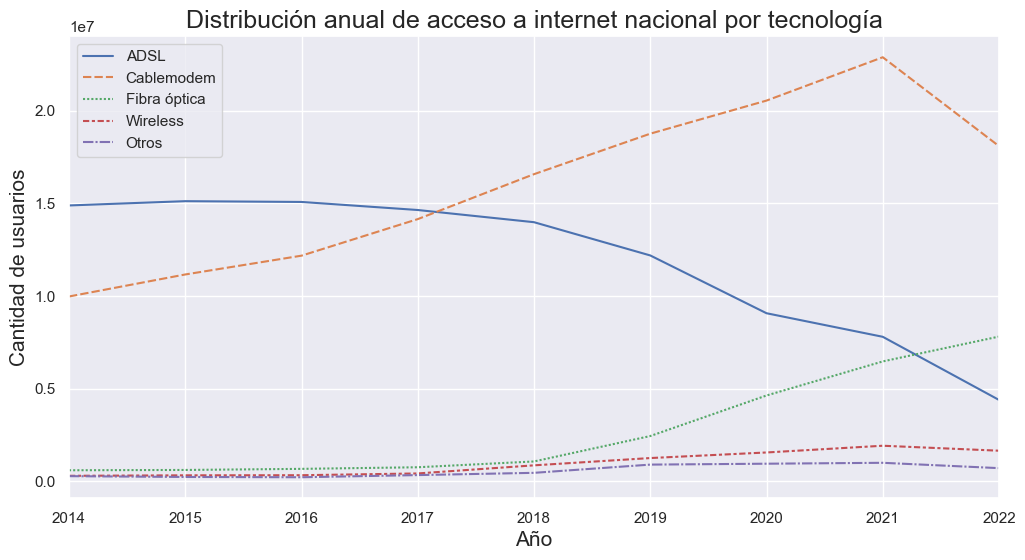

In [43]:
''' Observemos la evolución de la cantidad de usuarios de las diferentes tecnologías por año'''

label = list(reversed(list(df_tecnologia['Año'].unique())))

plt.figure(figsize = (12, 6))
sns.lineplot(df_tecnologia.groupby(['Año'])[['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros']].sum().reset_index().drop(columns = ['Año']))
plt.xlim(0, 8)
x_ticks = plt.xticks()[0]
plt.xticks(x_ticks, labels = label)
plt.ylabel('Cantidad de usuarios', fontsize = 15)
plt.xlabel('Año', fontsize = 15)
plt.title('Distribución anual de acceso a internet nacional por tecnología', fontsize = 18)

plt.show()

En el gráfico observamos que solo la fibra óptica se ha mantenido aumentando la cantidad de usuarios a lo largo de los años, las demás tecnologías disminuyen la cantidad de usuarios en los últimos años. Sin embargo, en el caso de Cablemodem su aumento fue constante hasta el 2021 y como ya se mencionó, los datos con los que contamos no tienen el cuarto trimestre del 2022, por lo que es posible que al añadir esos datos también haya un aumento de usuarios en cablemodem.

Este gráfico concuerda con los gráficos de cantidad de usuarios por velocidad, pues las tecnologías cablemodem y fibra óptica son las que proporcionan mejores velocidades de internet. La fibra óptica es la tecnología que proporciona mejores velocidades y un internet más estable, lo cual es de mucha importancia para personas que tengan trabajos remotos y, por lo general, suele ser más económicas que las otras tecnologías.

La empresa debe invertir en las mejores tecnologías (cablemodem y fibra óptica) las cuales proporcionan mayor estabilidad de la conexión de internet y mejores velocidades, esto es, como se pudo ver con los gráficos anteriores, lo que buscan los usuarios hoy en día.

In [44]:
''' Creemos un nuevo dataframe que contendrá la cantidad de usuarios para cablemodem y fibra óptica, los demás valores
    se agruparan en una columna llamada Otros, que contedrá la suma de los usuarios. También, eliminamos la columna
    total del dataframe de acceso por tecnología original'''

df_tecnologia_porcentaje = copy.deepcopy(df_tecnologia)
df_tecnologia_porcentaje['Otros'] = df_tecnologia_porcentaje['Otros'] + df_tecnologia_porcentaje['ADSL'] + df_tecnologia_porcentaje['Wireless']
df_tecnologia_porcentaje.drop(columns = ['ADSL', 'Wireless'], inplace = True)

df_tecnologia.drop(columns = ['Total'], inplace = True)


In [45]:
''' Dividimos las columnas cablemodem, fibra óptica y Otros entre el Total y multiplicamos por 100, para obtener
    el porcentaje de la pobalción para cada velocidad de conexión'''

df_tecnologia_porcentaje['Cablemodem'] = df_tecnologia_porcentaje['Cablemodem'] / df_tecnologia_porcentaje['Total'] * 100
df_tecnologia_porcentaje['Fibra óptica'] = df_tecnologia_porcentaje['Fibra óptica'] / df_tecnologia_porcentaje['Total'] * 100
df_tecnologia_porcentaje['Otros'] = df_tecnologia_porcentaje['Otros'] / df_tecnologia_porcentaje['Total'] * 100

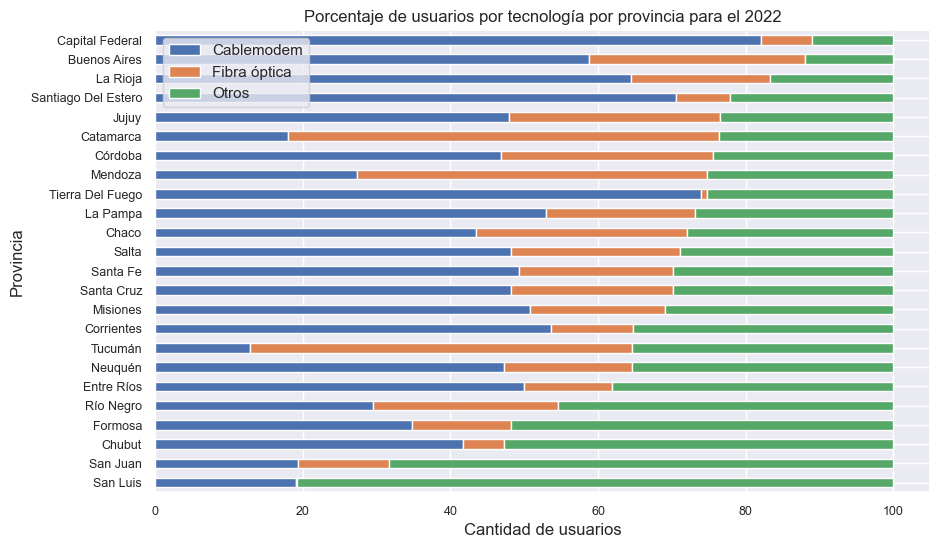

In [46]:
''' Observemos la cantidad de usuarios por tecnología por provincias para el año 2022'''

df_tecnologia_porcentaje[df_tecnologia_porcentaje['Año'] == 2022].groupby(['Provincia'])[['Cablemodem', 'Fibra óptica', 'Otros']].mean().sort_values(by = 'Otros', ascending = False).plot(kind = 'barh', stacked = True, title = 'Porcentaje de usuarios por tecnología por provincia para el 2022', figsize = (10, 6), ylabel = 'Provincia', xlabel = 'Cantidad de usuarios', fontsize = 9)

plt.show()

El gráfico nos muestra que, para el 2022, el cablemodem es la principal tecnología de internet utilizada en casi todas las provincias de Argentina. Además, se puede observar que la fibra óptica está presente en algunas provincias, específicamente las provincias más pobladas, como se observa en el gráfico de población por provincia. Esto tiene sentido por las tendencias que se ven en los gráficos de progresión anual: se observa una migración de usuarios a velocidades mayores de internet. Cablemodem y fibra óptica, son las 2 tecnologías con mayor velocidad de internet en el mercado.

En el caso de fibra óptica, donde está presente en las provincias más pobladas, indica primero que los usuarios necesitan velocidades de internet mayores a las que pueden conseguir con cablemodem y segundo  que la tecnología apenas está llegando a Argentina y creciendo en el país. Por ser una tecnología nueva, llega primero a los centros más poblados y desarrollados. Esto implica una gran oportunidad de crecimiento para la empresa, al invertir en fibra óptica y crecer a mayor velocidad que la competencia, las ganancias aumentarán por la alta migración de los usuarios de cablemodem a fibra óptica.

Vemos en el gráfico, como provincias como San Luis o San Juan, presentan poco porcentaje de usuarios con fibra óptica y cable modem. En estás provincias, por el tipo de geografía, es difícil realizar el despliegue de la infraestructura necesaria para brindar a los usuarios el servicio de internet por fibra óptica o cablemodem, es por esto que la principal tecnología que se espera en esas provincias es la wireless (inalámbrica). Está tecnología también ofrece internet de alta velocidad y es la mejor opción para zonas de difícil acceso, es decir, zonas montañosas o boscosas. Por esto, a pesar de que son pocos los usuarios que la usan, mientras se implementa la fibra óptica en zonas de difícil acceso, podría ser una buena opción para la empresa ofrecer internet a esas zonas por tecnología wireless.

**Veamos ahora si existe correlación entre las tecnologías y las velocidades.**

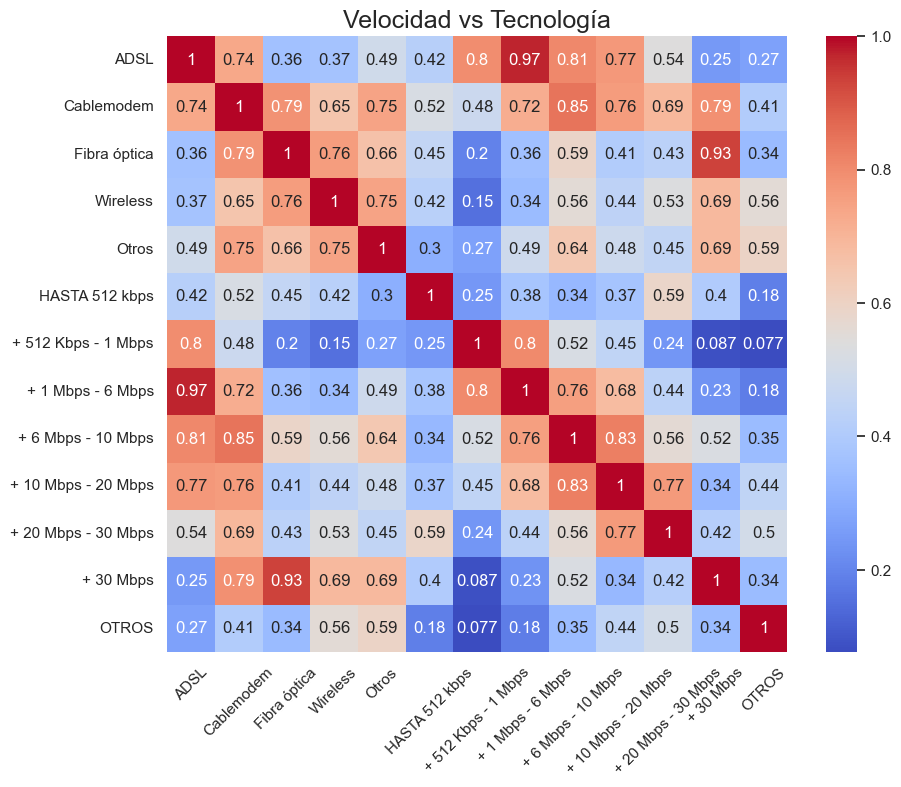

In [47]:
''' Veamos si existe correlación entre la velocidad y las tecnologías'''

correlacion = df_tecnologia.merge(df_acceso_velocidad_rangos_bajada_provincia, on = ['Año', 'Trimestre', 'Provincia']).corr(numeric_only = True)

plt.figure(figsize = (10, 8))
sns.heatmap(correlacion, annot = True, cmap= 'coolwarm')
plt.title('Velocidad vs Tecnología', fontsize = 18)
plt.xticks(rotation = 45)
plt.show()

En el mapa de calor podemos ver los valores numéricos de las correlaciones entre las diferentes tecnologías y los rangos de velocidad. Vemos fuerte correlación entre velocidad de +1 a 6 Mbps y ASDL, velocidades mayores a 30 Mbps y fibra óptica, y velocidades entre +6 a 10 Mbps y ASDL y cable modem. También buena correlación entre velocidades de +512 Kbps a 1 Mbps y ASDL, +10 a 20 Mpbs y ASDL y cablemodem, y +30 Mbps y cablemodem.

Esto tiene sentido, pues las mayores velocidades de internet son alcanzadas por tecnologías como cablemodem y fibra óptica, por lo que se espera una buena correlación entre esos valores. De igual forma, ASDL alcanza velocidades moderadas y por eso tienen buena correlación.

El mapa de calor nos ayuda a ver la importancia de la tecnología a la hora de tener una buena velocidad de internet. Por esto, es importante que la empresa invierta en las tecnologías que tengan mayor correlación con las altas velocidades: fibra óptica y cablemodem.

**A pesar de que la principal actividad de la empresa es el internet, por ser una compañía de telecomunicaciones, es importante analizar el comportamiento de la televisión, telefonía fija y telefonía móvil.**

### Televisión

In [48]:
''' Veamos el acceso a la televisión por suscripción y satelital a nivel nacional'''

df_tele_nacional = pd.read_csv('C:/Users/Luis/Documents/Universidad-Trabajo//SoyHenry/LABS/Proyecto_2/Datasets/television_nacional.csv', thousands = '.', decimal = ',')
df_tele_nacional.head()

,Año,Trimestre,Accesos TV por suscripción,Accesos TV satelital,Periodo
0,2022,3,7665931,2064699,Jul-Sept 2022
1,2022,2,7647584,2064637,Abr-Jun 2022
2,2022,1,7564827,2049628,Ene-Mar 2022
3,2021,4,7596758,2010217,Oct-Dic 2021
4,2021,3,7676892,2147571,Jul-Sept 2021


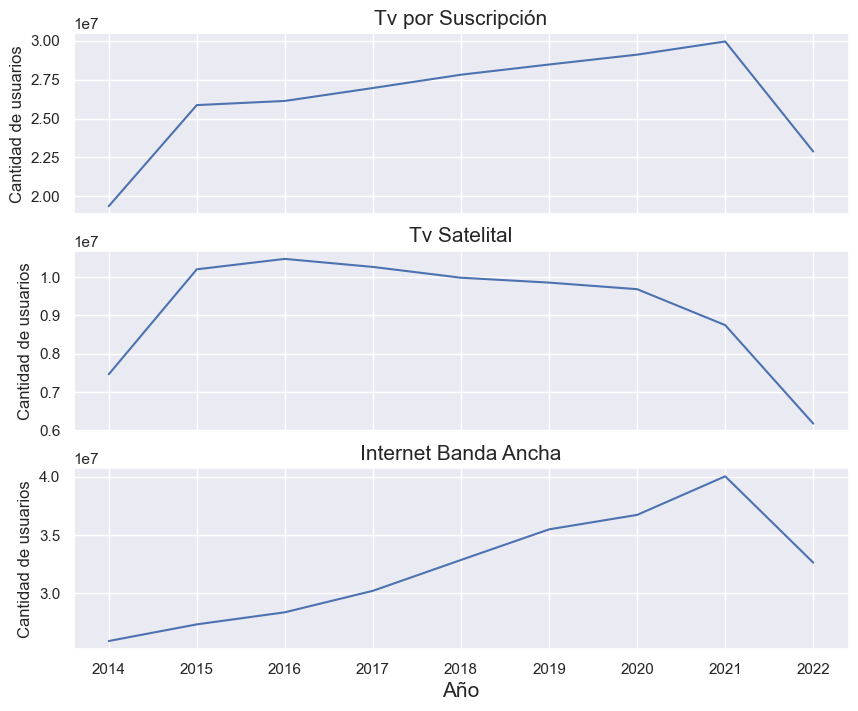

In [53]:
''' Veamos el progreso de los usuarios para ambos accesos de televisión y a internet banda ancha por año'''

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (10, 8), sharex = True)
sns.lineplot(df_tele_nacional.groupby(['Año'])[['Accesos TV por suscripción']].sum().reset_index(), x = 'Año',  y = 'Accesos TV por suscripción', ax = ax1)
ax1.set_title("Tv por Suscripción", fontsize = 15)
ax1.set_xlabel("Año")
ax1.set_ylabel("Cantidad de usuarios")

sns.lineplot(df_tele_nacional.groupby(['Año'])[['Accesos TV satelital']].sum().reset_index(), x = 'Año', y = 'Accesos TV satelital', ax = ax2)
ax2.set_title("Tv Satelital", fontsize = 15)
ax2.set_xlabel("")
ax2.set_ylabel("Cantidad de usuarios")

sns.lineplot(df_nacional_anual, x = 'Año', y = 'Banda ancha fija', ax = ax3)
ax3.set_title("Internet Banda Ancha", fontsize = 15)
ax3.set_xlabel("Año", fontsize = 15)
ax3.set_ylabel("Cantidad de usuarios")

plt.show()

En el caso de la Tv satelital vemos como la cantidad de suscriptores ha ido disminuyendo a medida que pasan los años. En el caso de la Tv por suscripción, hay un aumento hasta 2021 y luego disminuye bruscamente en el 2022, esto se debe a la falta de datos del cuarto trimestre del 2022 que ayudarían a reducir la diferencia. Además, vemos que en total la cantidad de usuarios de internet en el 2021 es de 40 millones, mucho mayor que los 30 millones para la Tv por suscripción y los 8 millones para la Tv satelital.

La disminución de suscriptores de Tv tiene relación con la cantidad de plataformas streaming (Netflix, Disney+, HBO MAX, etc) que hay disponibles actualmente. Los usuarios prefieren aprovechar el gran catálogo de estas plataformas, así como la alta calidad de video y la disponibilidad, en vez de pagar por el servicio de televisión. Esto guarda relación con el aumento de usuarios utilizando internet y, más aún, el aumento de usuarios con velocidades mayores a 30 Mbps, que indica una necesidad de altas velocidades para poder consumir el contenido streaming.

In [54]:
''' Ahora veamos el comportamiento de los accesos a TV por provincia'''

df_tele_provincia = pd.read_csv('C:/Users/Luis/Documents/Universidad-Trabajo//SoyHenry/LABS/Proyecto_2/Datasets/Television_provincia.csv', decimal = ',', thousands = '.')
df_tele_provincia.head()

,Año,Trimestre,Provincia,Accesos TV por suscripción
0,2022,3,Buenos Aires,2998021
1,2022,3,Capital Federal,743338
2,2022,3,Catamarca,52274
3,2022,3,Chaco,121771
4,2022,3,Chubut,80020


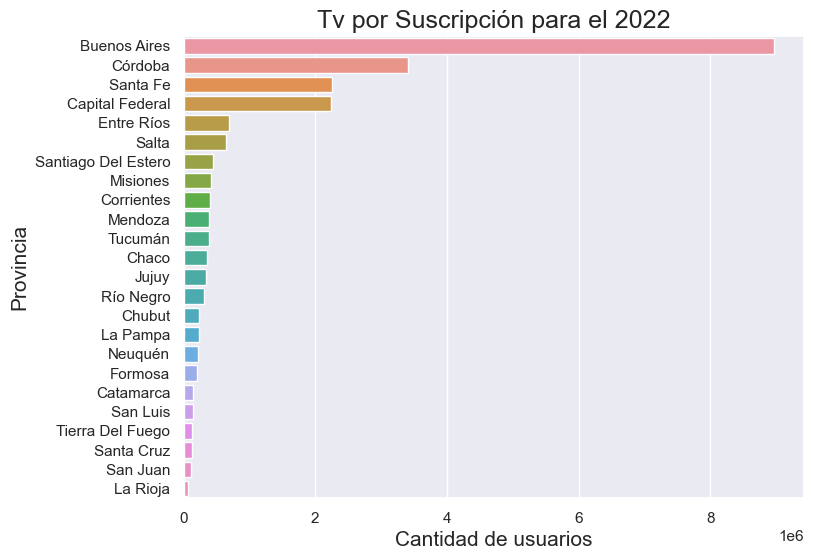

In [55]:
''' Veamos la cantidad de usuarios con acceso a Tv por suscripción para el año 2022'''

plt.figure(figsize = (8, 6))
sns.barplot(df_tele_provincia[df_tele_provincia['Año'] == 2022].groupby(['Provincia'])[['Accesos TV por suscripción']].sum().reset_index().sort_values(by = 'Accesos TV por suscripción',ascending = False), x = 'Accesos TV por suscripción', y = 'Provincia', orient = 'h')
plt.title('Tv por Suscripción para el 2022', fontsize = 18)
plt.xlabel('Cantidad de usuarios', fontsize = 15)
plt.ylabel('Provincia', fontsize = 15)

plt.show()

En el gráfico observamos que, nuevamente, las provincias más densamente pobladas son las que tienen mayor cantidad de suscriptores a Tv. 

Aquí hay dos posibilidades:

1.- La empresa aprovecha y presta el servicio de Tv por suscripción y/o satelital en las zonas donde hay menos  suscriptores, para aprovecha la posibilidad de crecimiento.

2.- La empresa puede ofrecer planes de internet en las zonas que tienen alta cantidad de usuarios suscritos a servicios de Tv que cuenten con servicios streaming como Netflix o Disney+, y así lograr la migración de los usuarios de tv a internet.

### Telefonía fija

In [56]:
''' Observemos el acceso a la telefonía fija'''

df_fija = pd.read_csv('C:/Users/Luis/Documents/Universidad-Trabajo//SoyHenry/LABS/Proyecto_2/Datasets/telefonia_fija.csv', decimal = ',', thousands = '.')
df_fija.head()

,Año,Trimestre,Provincia,Accesos telefonía fija (total),Accesos telefonía fija (hogares),Accesos telefonía fija (comercial),Accesos telefonía fija (gobierno),Accesos telefonía fija (otros)
0,2022,3,Buenos Aires,3422524,3129178,228867,15056,49423
1,2022,3,Capital Federal,1675854,1532216,112066,7372,24200
2,2022,3,Catamarca,25672,23471,1717,113,371
3,2022,3,Chaco,65662,60034,4391,289,948
4,2022,3,Chubut,72311,66114,4835,318,1044


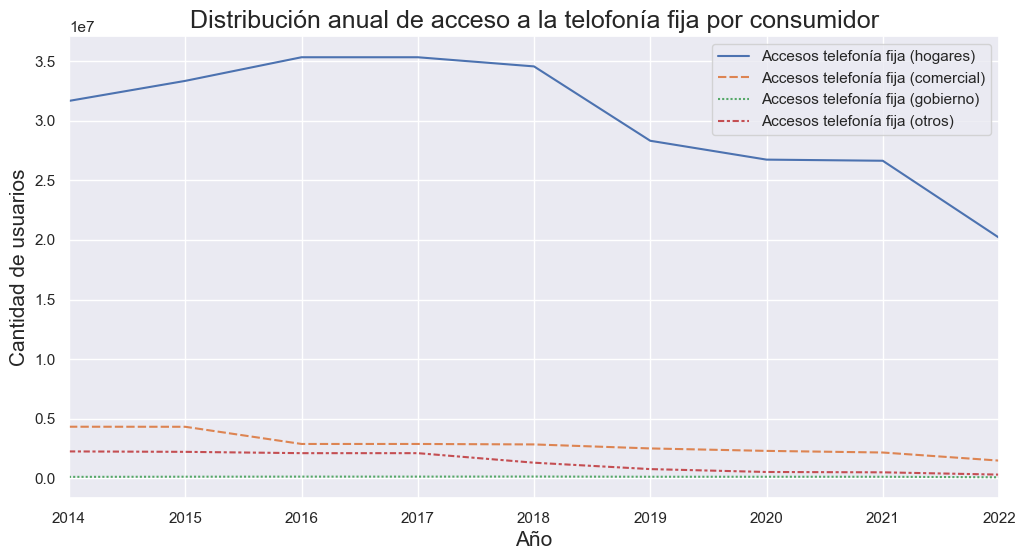

In [70]:
''' Observemos el comportamiento anual para los diferentes consumidores'''

label = list(reversed(list(df_fija['Año'].unique())))

plt.figure(figsize = (12, 6))
sns.lineplot(df_fija.groupby(['Año'])[['Accesos telefonía fija (hogares)', 'Accesos telefonía fija (comercial)', 'Accesos telefonía fija (gobierno)', 'Accesos telefonía fija (otros)']].sum().reset_index().drop(columns = ['Año']))
plt.xlim(0, 8)
x_ticks = plt.xticks()[0]
plt.xticks(x_ticks, labels = label)
plt.ylabel('Cantidad de usuarios', fontsize = 15)
plt.xlabel('Año', fontsize = 15)
plt.title('Distribución anual de acceso a la telofonía fija por consumidor', fontsize = 18)

plt.show()

En todos los casos de la telefonía fija, se observa una disminución de los usuarios a medida que pasan los años. Esto tiene sentido, la mayoría de las personas está migrando a telefonía móvil porque los teléfonos móviles tienen mayor capacidad, además de que los puedes llevar a todos lados contigo y cuentan con servicios de internet.

En este caso, la empresa puede crear planes que incluyan onu o modems inalámbricos, que faciliten la conexión de los teléfonos móviles a la red wifi, eliminando por completo el uso de teléfonos fijos y evitando que el usuario tenga que gastar en adquirir un router para poder tener wifi.

In [57]:
''' Se cambia el nombre de las provincias Tierra del Fuego y Santiano del Estero, para que coincidan con
    el nombre de las otras tablas'''

df_fija['Provincia'].replace({'Tierra del Fuego': 'Tierra Del Fuego', 'Santiago del Estero': 'Santiago Del Estero'}, inplace = True)

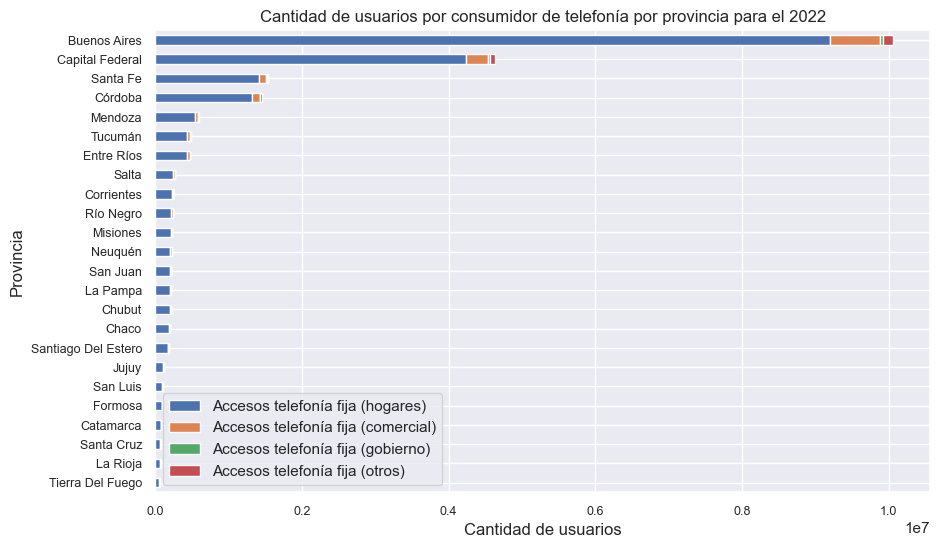

In [58]:
''' Veamos ahora la cantidad de usuarios por provincia para el 2022'''

df_fija[df_fija['Año'] == 2022].groupby(['Provincia'])[['Accesos telefonía fija (hogares)', 'Accesos telefonía fija (comercial)', 'Accesos telefonía fija (gobierno)', 'Accesos telefonía fija (otros)']].sum().sort_values(by = 'Accesos telefonía fija (hogares)', ascending = True).plot(kind = 'barh', stacked = True, title = 'Cantidad de usuarios por consumidor de telefonía por provincia para el 2022', figsize = (10, 6), ylabel = 'Provincia', xlabel = 'Cantidad de usuarios', fontsize = 9)

plt.show()

En el gráfico vemos que la mayor cantidad de consumidores de telefonía fija son los hogares y que las provincias con mayor cantidad de usuarios son las provincias más pobladas.

Esas provincias más pobladas son las que la empresa debe atacar, para lograr la migración de los usuarios de telefonía fija a internet, aplicando planes que faciliten el acceso y permita a los usuarios tener una buena conexión, como el descrito anteriormente.

### Telefonía móvil

In [59]:
''' Veamos el comportamiento de la telefonía móvil'''

df_movil = pd.read_csv('C:/Users/Luis/Documents/Universidad-Trabajo//SoyHenry/LABS/Proyecto_2/Datasets/telefonia_movil.csv', decimal = ',', thousands = '.')
df_movil.head()

,Año,Trimestre,Total de accesos pospago,Total de accesos prepago,Total de accesos operativos,Periodo
0,2013,1,7761349,57147608,64908957,Ene-Mar 2013
1,2013,2,7769110,58004822,65773932,Abr-Jun 2013
2,2013,3,8002183,59048909,67051092,Jul-Sept 2013
3,2013,4,8674516,58894516,67569032,Oct-Dic 2013
4,2014,1,8224482,54725089,62949571,Ene-Mar 2013


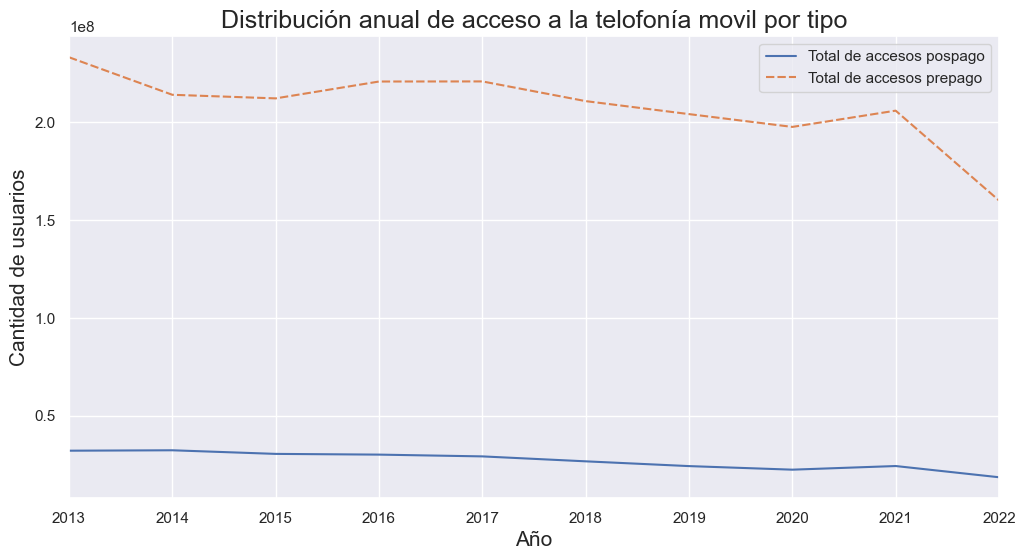

In [60]:
''' Observemos la evolución del acceso a la telefonía movil por año'''

label = list(df_movil['Año'].unique())

plt.figure(figsize = (12, 6))
sns.lineplot(df_movil.groupby(['Año'])[['Total de accesos pospago', 'Total de accesos prepago']].sum().reset_index().drop(columns = ['Año']))
plt.xlim(0, 9)
x_ticks = plt.xticks()[0]
plt.xticks(x_ticks, labels = label)
plt.ylabel('Cantidad de usuarios', fontsize = 15)
plt.xlabel('Año', fontsize = 15)
plt.title('Distribución anual de acceso a la telofonía movil por tipo', fontsize = 18)

plt.show()

En el gráfico vemos como la cantidad de usuarios se ha mantenido prácticamente constante tanto para prepago como para postpago. Solo en el año 2022 se ha visto una disminución significativa y se debe a la falta de datos del cuarto trimestre de ese año.

La empresa puede aprovechar y proporcionar onu o modems que cuenten con wifi, para dar acceso a los usuarios de telefonía móvil al internet y así aumentar la cantidad de usuarios conectados.

De igual forma, puede prestar el servicio de telefonía móvil con internet, lo que ayudaría a aumentar la cantidad de usuarios conectados y los ingresos de la empresa.

**Es importante que las acciones que se tomen sean en base a los datos y los insights obtenidos a partir de estos. Y que se busque la mejor forma, a través de publicidades, inversión, promociones o alianzas, para lograr captar la mayor cantidad de usuarios posibles y aumentar la rentabilidad de la empresa.**

### Preparación de los archivos 

In [61]:
''' Creamos una tabla calendario relacionar las diferentes fechas de las tablas'''

años = range(2014, 2023)
trimestres = [1, 2, 3, 4]
df_calendario = pd.DataFrame([(año, trimestre) for año in años for trimestre in trimestres], columns = ['Año', 'Trimestre'])
df_calendario['id'] = range(1, len(df_calendario) + 1)

In [62]:
''' Creamos una tabla provincia, para relacionar las provincias en todas las tablas'''

df_provincia = pd.DataFrame(df_poblacion['Provincia'].unique(), columns = ['Provincia'])
df_provincia['id'] = range(1, len(df_provincia) + 1)

In [63]:
''' Definimos las funciones que nos permitiran agregar los id a las diferentes tablas'''

def id_calendario(calendario, df):
    df = df.merge(calendario, on = ['Año', 'Trimestre'])
    df.rename(columns = {'id': 'id_calendario'}, inplace = True) 
    df.drop(columns = ['Año', 'Trimestre'], inplace = True)
    return df

def id_provincia(provincia, df):
    df = df.merge(provincia, on = ['Provincia'])
    df.rename(columns = {'id': 'id_provincia'}, inplace = True)
    df.drop(columns = ['Provincia'], inplace = True)
    return df

In [64]:
''' Aplicamos las funciones para colocar los id en las tablas'''

df_tecnologia = id_calendario(df_calendario, df_tecnologia)
df_tecnologia = id_provincia(df_provincia, df_tecnologia)

df_acceso_velocidad_rangos_bajada_provincia = id_calendario(df_calendario, df_acceso_velocidad_rangos_bajada_provincia)
df_acceso_velocidad_rangos_bajada_provincia = id_provincia(df_provincia, df_acceso_velocidad_rangos_bajada_provincia)

df_totales_acceso_fijo_bandas = id_calendario(df_calendario, df_totales_acceso_fijo_bandas)

df_100 = id_calendario(df_calendario, df_100)
df_100 = id_provincia(df_provincia, df_100)

df_acceso_provincia_bandas = id_calendario(df_calendario, df_acceso_provincia_bandas)
df_acceso_provincia_bandas = id_provincia(df_provincia, df_acceso_provincia_bandas)

df_tele_nacional = id_calendario(df_calendario, df_tele_nacional)

df_fija = id_calendario(df_calendario, df_fija)
df_fija = id_provincia(df_provincia, df_fija)

df_movil = id_calendario(df_calendario, df_movil)


In [65]:
''' Eliminamos la columna periodo de df_movil, df_tele_nacional y df_totales_acceso_fijo_bandas'''

df_movil.drop(columns = ['Periodo'], inplace = True)
df_tele_nacional.drop(columns = ['Periodo'], inplace = True)
df_totales_acceso_fijo_bandas.drop(columns = ['Periodo'], inplace = True)             

In [66]:
''' Creamos los archivos .csv limpios, estos se usaran en caso de que haya algún problema con la base de datos'''

df_tecnologia.to_csv('C:/Users/Luis/Documents/Universidad-Trabajo/SoyHenry/LABS/Proyecto_2/Datasets_PBI/Acceso_teconlogia.csv')
df_acceso_velocidad_rangos_bajada_provincia.to_csv('C:/Users/Luis/Documents/Universidad-Trabajo/SoyHenry/LABS/Proyecto_2/Datasets_PBI/Acceso_rangos_velocidad_provincia.csv')
df_totales_acceso_fijo_bandas.to_csv('C:/Users/Luis/Documents/Universidad-Trabajo/SoyHenry/LABS/Proyecto_2/Datasets_PBI/Acceso_banda_nacional.csv')
df_100.to_csv('C:/Users/Luis/Documents/Universidad-Trabajo/SoyHenry/LABS/Proyecto_2/Datasets_PBI/Acceso_100_hogares.csv')
df_acceso_provincia_bandas.to_csv('C:/Users/Luis/Documents/Universidad-Trabajo/SoyHenry/LABS/Proyecto_2/Datasets_PBI/Acceso_provinca_banda.csv')
df_tele_nacional.to_csv('C:/Users/Luis/Documents/Universidad-Trabajo/SoyHenry/LABS/Proyecto_2/Datasets_PBI/Acceso_tv_nacional.csv')
df_fija.to_csv('C:/Users/Luis/Documents/Universidad-Trabajo/SoyHenry/LABS/Proyecto_2/Datasets_PBI/telefonia_fija.csv')
df_movil.to_csv('C:/Users/Luis/Documents/Universidad-Trabajo/SoyHenry/LABS/Proyecto_2/Datasets_PBI/telefonia_movil.csv')
df_poblacion.to_csv('C:/Users/Luis/Documents/Universidad-Trabajo/SoyHenry/LABS/Proyecto_2/Datasets_PBI/Poblacion_Argentina.csv')
df_provincia.to_csv('C:/Users/Luis/Documents/Universidad-Trabajo/SoyHenry/LABS/Proyecto_2/Datasets_PBI/Provincias.csv')
df_calendario.to_csv('C:/Users/Luis/Documents/Universidad-Trabajo/SoyHenry/LABS/Proyecto_2/Datasets_PBI/Calendario.csv')